# Data Handling

This seminar on Oceanographic Data Processing focuses on techniques in handling, analyzing, and visualizing large and complex datasets using Python. Key topics include:

    Data Aggregation: Techniques to read and combine multiple datasets from various sources, enabling broader insights and pattern recognition.

    Advanced Statistical Calculations: In-depth exploration of annual metrics.

    Time Series Analysis: Understanding trends and cyclic patterns in time series data.

    Automated Data Retrieval: Learning to automatically download data, including using OpenDAP for large datasets without specific access keys.

    Multidimensional Data Manipulation: Expanding from monthly to annual and longer data analysis by organizing data into multidimensional arrays.

In [18]:
# Standard libraries
import os

# Scientific libraries
import numpy as np
import pandas as pd
import xarray as xr
from scipy.signal import detrend

#Visualization libraries

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt







%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## datapath and filename
datapath = '../Data/Wind'

shapefile = '../Data/110m_cultural/ne_110m_admin_0_countries.shp'

In the following code, we're performing the following tasks:

**File Paths for 2023 Wind Data:** We're setting up file paths for data corresponding to each month of the year 2023. For this we create a dictionary. When you start the 1. Exercise you will see the structure of a dictionary. There is also an example in the Python_cookbook.ipynb - Notebook.

**Loading the Data:** Using [`xr.open_mfdataset()`](https://docs.xarray.dev/en/stable/generated/xarray.open_mfdataset.html), we're loading multiple netCDF datasets at once, which represent monthly data throughout 2023, and combining them by coordinates.


In [21]:
# run the cell

# Load data
# Define file paths for the year 2023
data_ranges = {year: list(range(1, 13)) for year in range(2023, 2024)}

filenames = [os.path.join(datapath, f'cmems_obs-wind_glo_phy_my_l4_P1M_{year}{str(month).zfill(2)}.nc') 
              for year, months in data_ranges.items() for month in months]

# Load all files for 2023 using open_mfdataset and combine them by coordinates (lat, lon)
ds_2023 = xr.open_mfdataset(filenames, combine='by_coords') # mf = multible files

**1. Exercise:**  
To check the contents of `data_ranges`, `filenames`, and `ds_2023`, simply enter these variable names into the following code cells.

In [ ]:
# your code here


In [ ]:
# your code here


In [ ]:
# your code here


### Optimizing Large Datasets with Dask in xarray


The term `dask.array` in your xarray dataset indicates that Dask is being used for efficient computation and memory management. `open_mfdataset()` uses this by default to handle large datasets by loading them in chunks.

    Dask Integration: Dask enables parallel and out-of-core computation, making it ideal for datasets too large to fit into memory.
    Chunksize: The dataset is divided into chunks (e.g., 1 time step, 720 latitudes, 1440 longitudes), allowing for efficient processing by loading only necessary chunks.
    Lazy Evaluation: Calculations are performed only when needed, improving efficiency for large datasets.


In summary, your dataset is an xarray dataset with monthly wind data, and the use of Dask indicates that it's optimized for large-scale, possibly memory-intensive computations, with data stored in chunks and processed using parallel computing techniques.


You successfully combined multible monthly data fields to a multidimensional xarray. Now, let's calculate wind speed variability for 2023 using `std()` to identify regions with the greatest variability.


In [ ]:
# run the cell

# Calculate the wind speed from the eastward and northward components and the variability of wind speed using std()
wind_speed_variability = ((ds_2023['eastward_wind']**2 + ds_2023['northward_wind']**2)**0.5).std(dim='time')

# Plot the regions with the highest variability
wind_speed_variability.plot()

And a plot with landmasses: 

In [ ]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 7))

# Define the map projection using Robinson (Basemap for Robinson projection)
m = Basemap(projection='robin', lon_0=0, ax=ax)

# Get longitude and latitude data from the dataset


# Create a meshgrid for plotting
lon2d, lat2d = np.meshgrid(wind_speed_variability.lon, wind_speed_variability.lat)

# Transform the coordinates into the Robinson projection
x, y = m(lon2d, lat2d)

# Define levels for contouring (for eastward wind)
levels = np.linspace(0, 4, 25)

# Plot the eastward wind data using contourf
cs = m.contourf(x, y, wind_speed_variability, cmap='viridis', levels=levels)

# Add a colorbar
cbar = m.colorbar(cs, location='right', pad="10%",ticks=np.arange(0, 4.1, .5))

cbar.set_label(f'Wind Speed Variability (m s-1)')


# Use Basemap to fill continents with white
m.fillcontinents(color='white')

# Draw coastlines (only coastlines, no rivers)
m.drawcoastlines()

# Add gridlines (parallels and meridians) for the Robinson projection
m.drawparallels(np.arange(-90., 91., 30.), labels=[1, 0, 0, 0], linewidth=0.5, color='gray')
m.drawmeridians(np.arange(-180., 181., 40.), labels=[0, 0, 0, 1], linewidth=0.5, color='gray')

#
# Set a title based on the dataset
plt.title(f"Wind Speed Variability (m s-1))")
# Save the figure with a transparent background
#plt.savefig("wind_speed_variability_plot.png", transparent=True)
# Show the plot
plt.show()


There are a few regions where wind variability is enhanced, such as the Indian Ocean. Let's explore which month has the highest mean wind speed.

### Loop

First, we'll slice the data to focus on the Indian Ocean region, as we have done in the last session. Then, we calculate the monthly wind speed using both the northward and eastward wind components. We'll **loop** through each month to average the wind data across the central Indian Ocean, giving us the mean wind speed for each month.

Before calculating the mean wind speed for each month in the Indian Ocean, we first mask the wind data to ensure that land values do not affect our results. We use the `number_of_observations` variable in the dataset to create this mask.

In [ ]:
# plot number_of_observations using the built-in method



In [ ]:
# run the cell 

#'number_of_observations' is the variable used as a mask
mask = ds_2023.number_of_observations.notnull()

# Apply the mask to the eastward wind data
ds_masked = ds_2023.where(mask)

# Plot the masked eastward wind data
ds_masked.eastward_wind[11,:,:].plot(cmap='coolwarm', figsize=(12, 5))

# Show the plot
plt.show()

For calculating the mean values, we will now use the masked data. The region we are focusing on includes landmasses, and our dataset contains measurements for those areas. Including them in the calculations would distort the results, as we are only interested in the wind over the ocean. **Optional:** You can also test this yourself. First run the following cell and then use `ds_2023` instead of `ds_masked` in the calculations and compare the results.

In [ ]:
# run the cell



# Define the region for the Indian Ocean
# Indian Ocean (Latitudes: -20 to 20, Longitudes: 50 to 100)
indian_ocean_wind = ds_masked.sel(lat=slice(-20, 20), lon=slice(50, 100))

# List to store the mean wind speed for each month
mean_wind_speeds = []

# Loop through each month to calculate the mean wind speed in the Indian Ocean
for month in range(1, 13): #-> 1:13 range() includes the start value but excludes the end value, so range(1, 13) returns numbers from 1 to 12
    # Select data for the current month
    monthly_data = indian_ocean_wind.sel(time=indian_ocean_wind['time.month'] == month)
    
    # Calculate wind speed
    wind_speed = (monthly_data['eastward_wind']**2 + monthly_data['northward_wind']**2)**0.5
    
    # Calculate the mean wind speed over the region
    # Since we are using Dask for parallel computation, we need to call compute() to finalize the calculation
    mean_wind_speed = wind_speed.mean(dim=['lat', 'lon']).values#.compute().values 
    
    # Append the mean wind speed for this month
    mean_wind_speeds.append(mean_wind_speed)
# Create a time series using Pandas DataFrame
months = pd.date_range(start='2023-01', periods=12, freq='MS')
wind_speed_series = pd.DataFrame({'Month': months.strftime('%Y-%m'), 'Mean Wind Speed': mean_wind_speeds})

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(wind_speed_series['Month'], wind_speed_series['Mean Wind Speed'], marker='o', linestyle='-', color='b')
plt.title('Mean Wind Speed in the Indian Ocean (2023)')
plt.xlabel('Month')
plt.ylabel('Mean Wind Speed (m s-1)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Find the top 3 month with the highest mean wind speed:

In [ ]:
# run the cell 
# Sort the DataFrame by 'Mean Wind Speed (m/s)' in descending order and select the top 3 months
top_3_months = wind_speed_series.sort_values(by='Mean Wind Speed', ascending=False).head(3)

# Output the result
print("Top 3 months with the highest mean wind speed:")
print(top_3_months)

<span style="color:royalblue">Honestly, there's a much easier way to get the monthly data. I just wanted to show you another loop as an example of how you can approach this problem in different ways! Now, let’s move on to the more straightforward approach when analyzing xarray data.</span>

In [ ]:
# run the cell
# Calculate wind speed
wind_speed = (indian_ocean_wind['eastward_wind']**2 + indian_ocean_wind['northward_wind']**2)**0.5

# Calculate the mean wind speed over lat and lon
mean_wind_speed = wind_speed.mean(dim=['lat', 'lon']).compute()  
# We used compute() to bring data into memory, argsort didn't work on Dask Arrays

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(mean_wind_speed['time'], mean_wind_speed.values, marker='o', linestyle='-', color='b')
plt.title('Mean Wind Speed in the Indian Ocean (2023)')
plt.xlabel('Month')
plt.ylabel('Mean Wind Speed (m s-1)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The wind speeds are highest in the central Indian Ocean between July and September due to the influence of the southwest monsoon. During this period, strong winds blow from the ocean toward the Indian subcontinent, driven by temperature differences between the land and sea. This monsoon system brings higher wind speeds, particularly over the central and northern parts of the Indian Ocean, contributing to more intense weather patterns in the region.


### Multidimensional Climate Data 

You might be wondering why we haven't yet analyzed oceanographic data. However, wind is a crucial climate variable that significantly impacts oceanographic processes such as currents and upwelling, which in turn affect sea temperature or salinity etc. Therefore, analyzing wind alongside other variables is a common practice in oceanography. Next, we will begin examining Sea Surface Temperature (SST) data, which we will access directly from NOAA using the OPeNDAP protocol (or from the HCU Cloud if the protocol encounters any issues or directly: https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/).


In [ ]:
#run the cell
#load SST data
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds_sst = xr.open_dataset(url)
ds_sst

Note: If the URL from above didn't work, you can download the data via HCU Cloud:To run the code, please remove the # symbols before the lines:

In [ ]:
##in case of OpeNDAP Problems
##load SST data
#import requests
## Define the cloud link
#url = 'https://cloud.hcu-hamburg.de/nextcloud/s/JmYoZ2zaXGQdWp6/download' 

## Download the file
#filename = 'sst_data.nc'
#response = requests.get(url)

## Save the file locally
#with open(filename, 'wb') as file:
#    file.write(response.content)

## Now open the file using xarray
#ds_sst = xr.open_dataset(filename, use_cftime=True)
#ds_sst


**2. Exercise: Slice the data and select a more recent part of the data (e.g. 1960-2023)**

Name the sliced data also `ds_sst`. We overwrite the loaded ds_sst.

In [30]:
# your code here


We also want to examine whether the SST shows increased variability in the Indian Ocean. In the following steps, we will slice the SST data for the year 2023, focusing on the same region as we did for the wind data, and plot the time series.

However, there are some differences compared to the wind data. For instance, the latitude in the SST dataset starts from the Northern Hemisphere and moves southward, whereas the wind data starts from the Southern Hemisphere. Additionally, the longitude in the SST dataset spans from 0 to 360 degrees, unlike the wind data, which uses the range from -180 to 180 degrees. For the Indian Ocean, the longitude remains the same, but we need to adjust the slicing for latitude accordingly.


In [ ]:
# Define the region for the Indian Ocean
# Indian Ocean (Latitudes: -20 to 20, Longitudes: 50 to 100)
indian_ocean_sst = ds_sst.sel(lat=slice(20, -20), lon=slice(50, 100),time = slice('2023','2024'))
indian_ocean_sst['sst'].std(dim='time', skipna=True).plot()

The plot also reveals higher variability near coastal areas and south of 10°S, where wind speed variability is also enhanced.

We now want to calculate the mean SST for the Indian Ocean and plot the time series, similar to what we did for the wind data.

**3. Exercise: Copy the code from above, where we calculated and plotted the mean Indian Ocean wind speed using `xarray`. Modify this code to calculate and plot the mean SST from `indian_ocean_sst` instead (without using loops or lists). Name it `mean_sst`.**

Hint: Focus on calculating and plotting the mean values over time.



In [ ]:
# your code and plot here


This is quite interesting: SST shows its lowest values when wind speed is at its peak. To make this relationship clearer, let's plot both time series together. **Check, if your variable_names match, otherwise modify**

In [ ]:
# run the cell

# Create the figure and the first axis (for SST)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the SST data on the left y-axis
ax1.set_xlabel('Month')
ax1.set_ylabel('Mean SST (°C)', color='r')
ax1.plot(mean_sst['time'], mean_sst['sst'].values, marker='o', linestyle='-', color='r', label='Mean SST')
ax1.tick_params(axis='y', labelcolor='r')

# Create a second y-axis for wind speed
ax2 = ax1.twinx()  # This creates a second y-axis that shares the same x-axis
ax2.set_ylabel('Mean Wind Speed (m/s)', color='b')
ax2.plot(mean_wind_speed['time'], mean_wind_speed.values, marker='o', linestyle='-', color='b', label='Mean Wind Speed')
ax2.tick_params(axis='y', labelcolor='b')

# Set the title and layout
plt.title('Mean SST and Wind Speed in the Indian Ocean (2023)')


plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Variabilities on various timescales

The monsoon for example represents a clear seasonal signal in the Indian Ocean, which is also present in wind and sst. In climate science, analyzing seasonal trends is crucial for understanding the temporal dynamics of various climatic parameters, including sea surface temperature (SST). Seasonal variations in SST significantly impact weather patterns, marine ecosystems, and global climate systems. By examining seasonal means, we capture the typical state of the climate system at different times of the year, revealing patterns that may be obscured in longer-term averages.

Seasonal means help highlight systematic changes caused by the Earth's tilt and orbit. Analyzing the standard deviation alongside the mean reveals how much variability exists during each season. High standard deviation indicates greater variability, while low values suggest more stable conditions.

**Steps:** 

We calculate the seasonal means and standard deviations for the sea surface temperature (SST) data provided in the `ds_sst` dataset. This dataset contains monthly SST data over several decades.

1. Calculation of the Seasonal Means: We group the data by the meteorological seasons (DJF for winter, MAM for spring, JJA for summer, and SON for autumn) and calculate the mean SST for each season using `groupby('time.season').mean('time')`.  

2. Visualizing the Results: We create a set of plots to visualize the seasonal means. There will be be one plot for each season. We use a clear and contrast-rich colormap like `plasma.` Ensure that the variables in your calculations match those expected by the given plot code.  

Note: The provided plot code offers a straightforward approach to plotting, ideal for an expeditious examination of results. We're bypassing the more intricate plot embellishments in favor of leveraging the integrated contour features of xarray, which utilizes Matplotlib's capabilities. This allows for a swift and efficient overview of the data without the additional complexity of extensive customization. However, it's worth noting that further enhancements can be made for more refined visual presentations, as demonstrated earlier.

In [23]:
#run the cell

#calculation of seasonal means
#seasonal_means = ds_sst['sst'].groupby('time.season').mean('time') # needs sometimes a lot of time-> chunk the dataset

# Chunk the dataset for parallel processing
ds_sst_chunked = ds_sst.chunk({'lat': 30, 'lon': 60})  # Adjust chunk size to optimize memory usage

# Calculate seasonal means and trigger computation (Dask uses lazy evaluation, 
# but computing upfront may speed up later operations like plotting)
seasonal_means = ds_sst_chunked['sst'].groupby('time.season').mean('time').compute()



In [ ]:
#run this cell, check variable names

# Define the seasons order and titles for the plot
seasons = ['DJF', 'MAM', 'JJA', 'SON']
titles = ['Winter (DJF)', 'Spring (MAM)', 'Summer (JJA)', 'Autumn (SON)']

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), constrained_layout=True)

# Define the levels for contouring
temperature_levels = np.arange(-2, 28.5, 0.5)

for i, season in enumerate(seasons):
    # Select the appropriate subplot
    ax = axes.flatten()[i]
    
    # Plot the seasonal mean with a colormap designed for better visibility
    im = seasonal_means.sel(season=season).plot(
        ax=ax, add_colorbar=False, 
        cmap='plasma', levels=temperature_levels
    )
    
    # Add contour lines to emphasize the differences
    seasonal_means.sel(season=season).plot.contour(
        ax=ax, colors='k', levels=temperature_levels, linewidths=0.5, alpha=0.5
    )
    
    # Set the title to the current season
    ax.set_title(titles[i])

    # Adjust the colorbar
    cbar = fig.colorbar(im, ax=ax, extend='both')
    cbar.set_label('Sea Surface Temperature (°C)')

    # Adjust the color scale limits
    im.set_clim(-2, 30)

# Adjust the layout and display the plot
plt.show()

**4. Exercise** 
1. Similar to the means, calculate the standard deviations for each season by grouping `ds_sst_chunked` by season and using `.std('time')` instead of `.mean('time')`. Visualize them using the provided plot code, adjusting the colorbar limitations and temperature levels accordingly to reflect the variability.

2. Reflect on the Standard Deviations: Consider what the standard deviations might reveal and hypothesize what factors might contribute to the observed variability.

Discuss the Findings: Once you have your plots, write a brief analysis discussing any noticeable patterns or differences between the seasons.

In [25]:
# Your calculation of seasonal stds using ds_sst_chunked



In [ ]:
# copy the code from plotting the mean and adjust temperature levels and rename seasonal_means by seasonal_stds



**5. Exercise: Describe your Observations:**

....Your observations here


### Long-term Trend

As we observed the seasonal standard deviations, you may have noticed increased variability not only in the mid-latitudes but also near the equatorial Pacific. This region is notably affected by the El Niño-Southern Oscillation (ENSO), a key driver of interannual climate variability.

Climate variability occurs across different timescales. In addition to seasonal or interannual fluctuations, there is a long-term trend in sea surface temperature (SST) due to global warming. By understanding the long-term trend and variations on other timescales, we can better interpret the underlying processes driving these changes.

In the following we calculate and plot the long-term trend, more precise, the trend per decade (period 1960-2023). Simply run the next cell and have a closer look.



In [ ]:
# run the cell

# Import the functions
from trend_analysis import calculate_trend_per_decade, plot_trend_with_basemap

# Assuming you have detrended SST data (sst_anom_detrended)
# Calculate the trend per decade
trend_decade = calculate_trend_per_decade(ds_sst.sst)

plot_trend_with_basemap(trend_decade, vmin =-.5, vmax = .5, central_lon = 180)

Same plot, but now focused on the Atlantic Ocean.

In [ ]:
# run the cell
plot_trend_with_basemap(trend_decade, vmin =-.5, vmax = .5, central_lon = 0)

Run the next cell to calculate the mean global SST trend per decade. Does this result seem realistic? **Search for relevant literature to verify your findings.**

In [ ]:
# run the cell
trend_decade.mean()

### Monthly Climatology and Anomalies

In this exercise, we will calculate monthly climatology and anomalies. Anomalies represent deviations from the long-term monthly climatological mean and help us study e.g. interannual climate variability, such as ENSO events, by removing both the long-term trend and seasonal cycles.

By calculating anomalies, we can better focus on the effects of events like El Niño and La Niña, which cause variations on interannual timescales.

**6. Exercise: Calculate Monthly Climatology and Anomalies**

- Climatology: Compute the long-term monthly averages from `ds_sst['sst']` (e.g., the average of all January values, February values, etc.). Use the `groupby('time.month')` function to group the data by month, then apply the `mean()` function along the time dimension to compute these monthly means.

- Anomalies: Subtract the monthly climatology from each corresponding monthly value of `ds_sst['sst']` to calculate the anomalies. Use `groupby('time.month')` again to ensure that the months are aligned correctly before subtracting.

Steps:

- First, calculate the monthly climatology for the given time period (e.g., 1960–2023).
- Next, compute the anomalies by subtracting the climatology from the original dataset.


In [ ]:
# your code here
# sst_clim = 


In [39]:
#your code here
#sst_anom = 


You calculated monthly anomalies, which means the seasonal cycle has been removed. Now, we can focus on removing long-term trends from these anomalies. This step isolates variabilities on other timescales (e.g. interanual) by subtracting both the seasonal and long-term trends.

Let's visualize the anomalies to see how the seasonal cycle has been removed, and then proceed with detrending to eliminate the long-term warming trends.

In [ ]:
#run the cell

lat_weights = np.cos(np.deg2rad(ds_sst.lat)).where(~sst_anom[0].isnull())
lat_weights /= lat_weights.mean() # deviding each element by the mean of the entire array (Normalization)

#  Calculate the global mean of the original data (weighted by latitude)
global_sst_original = (ds_sst['sst'] * lat_weights).mean(dim=['lon', 'lat'])

# Calculate the global mean of the anomalies (weighted by latitude)
global_sst_anom = (sst_anom * lat_weights).mean(dim=['lon', 'lat'])

# Define the time range
time_range = slice('1990', '2024')

# Plot the original data and the anomalies using two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the original SST data on the left y-axis
ax1.set_xlabel('Time')
ax1.set_ylabel('Original SST (°C)', color='blue')
ax1.plot(global_sst_original['time'].sel(time=time_range),global_sst_original.sel(time=time_range), label='Original SST', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the anomalies
ax2 = ax1.twinx()  # Create a second y-axis that shares the same x-axis
ax2.set_ylabel('SST Anomalies (°C)', color='red')
ax2.plot(global_sst_anom['time'].sel(time=time_range),global_sst_anom.sel(time=time_range), label='SST Anomalies (Seasonal Cycle Removed)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_xlabel('Time')

ax1.grid(True)  # Grid for the first axis

# Set the title and layout
plt.title('Comparison: Global Mean SST vs. Anomalies')
fig.tight_layout()
# Automatically format the x-axis for better display
fig.autofmt_xdate()
# Show the plot
plt.show()


### Detrending

Detrending removes long-term trends from the data. Before detrending, we check for missing values (NaNs) to ensure they occur only over land. NaN values within the data can cause problems when detrending, so we need to interpolate them. However, if NaNs are present only over land, we can simply replace them with zeros.

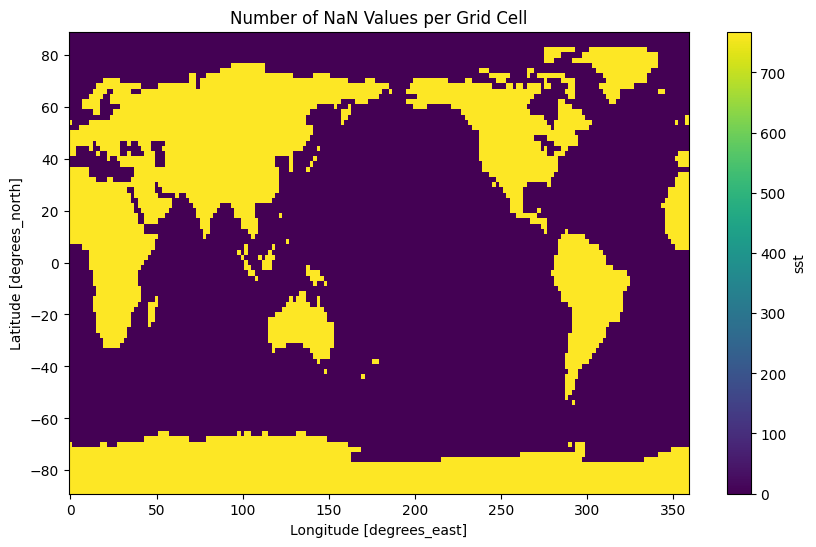

In [41]:
# run the cell

# Count the number of NaNs per grid point across the time dimension
nan_mask = sst_anom.isnull().sum(dim='time')

# Plot the NaN mask to visualize where NaN values are present
plt.figure(figsize=(10, 6))
nan_mask.plot()
plt.title('Number of NaN Values per Grid Cell')
plt.show()

We temporarily fill these NaNs with zeros for processing and later revert them back to NaNs to preserve the dataset's integrity.

We use `apply_ufunc()` to apply the detrend function along the time axis, which removes any linear trends. Afterward, we ensure the original NaN positions are restored.

In [40]:
# run the cell
sst_anom_detrended = xr.apply_ufunc(detrend, sst_anom.fillna(0),
                                    input_core_dims=[['time']],output_core_dims=[['time']] , dask='allowed').where(~sst_anom.isnull())

Examine the detrended and raw SST anomaly time series averaged globally. Execute the following cell to generate a plot depicting the globally averaged SST anomalies over time. Ensure that the variable names in the code match those you have defined in your environment.

In [ ]:
# run the cell

# For a global average, we need to weigh the points by cosine of latitude.
lat_weights = np.cos(np.deg2rad(ds_sst.lat)).where(~sst_anom[0].isnull())
lat_weights /= lat_weights.mean() # deviding each element by the mean of the entire array (Normalization)

(sst_anom * lat_weights).mean(dim=['lon', 'lat']).plot(label='raw SST anomalies',color = 'b')
(sst_anom_detrended * lat_weights).mean(dim=['lon', 'lat']).plot(label='detrended SST anomalies', color = 'r')
plt.grid()
plt.legend()
# Add axis labels
plt.xlabel('Time')  # x-axis is time
plt.ylabel('Global Average SST Anomaly (°C)')  # Adjust the units if they're different. 
#Sea Surface Temperature (SST) anomalies are commonly reported in Kelvin (K), but it's also frequent to see them presented in degrees Celsius (°C) in the scientific literature.



# Interannual Variabilities

After calculating the monthly detrended anomalies, we can now examine how SST may vary during El Niño and La Niña events. To do this, we calculate composites, which involves identifying El Niño and La Niña periods and isolating the corresponding SST anomalies. Over a span of more than 30 years, we average the SST anomalies for both El Niño (positive phase) and La Niña (negative phase) events. For more details, refer to the functions in [`enso_functions.py`](enso_functions.py).  We'll explore functions and modules in more depth during the next session.

In [ ]:
# run the cell

# Import the ENSO functions from the external script
from enso_functions import calculate_nino34_index, calculate_composites, plot_composites

# Assuming you have already loaded and detrended your SST anomaly dataset (sst_anom_detrended)

# Step 1: Calculate the Niño3.4 index using the SST anomalies
nino34_index = calculate_nino34_index(sst_anom_detrended)

# Step 2: Calculate the SST composites for positive and negative ENSO events
sst_anom_positive, sst_anom_negative = calculate_composites(sst_anom_detrended, nino34_index)

# Step 3: Plot the SST composites
plot_composites(sst_anom_positive, sst_anom_negative)


**7. Exercise: Discuss the plot of the composites with your neighbor. What patterns do you observe, and what might they indicate?**


Further reading:   
[El Niño/Southern Oscillation - Introduction](https://www.ncei.noaa.gov/access/monitoring/enso/)  
[El Niño/Southern Oscillation - SST](https://www.ncei.noaa.gov/access/monitoring/enso/sst)   
[Nino SST Indices (Nino 1+2, 3, 3.4, 4; ONI and TNI)](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni)  

What are Composites:  
Composites involve averaging data over specific conditions or events (like El Niño or La Niña). To calculate an ENSO composite, we first identify the periods of positive (El Niño) and negative (La Niña) phases based on a threshold value of the Niño 3.4 index. Then, we isolate the corresponding SST anomalies for those events and calculate the mean anomaly during those times. This allows us to compare the average SST patterns during El Niño and La Niña events, highlighting the spatial impacts of these climate phenomena.
You can check the code example in [enso_functions.py](enso_functions.py), which demonstrates this, where we first calculate the Niño 3.4 index from the SST anomalies, identify positive and negative ENSO events, and then calculate and plot the composites.



